<h1> GoFast  </h1>

Будем анализировать популярный сервис аренды самокатов GoFast. У нас есть данные о некоторых пользователях из нескольких городов, а также об их поездках. Нужно проанализировать данные и провереть некоторые гипотезы, которые могут помочь бизнесу вырасти.

Чтобы совершать поездки по городу, пользователи сервиса GoFast пользуются мобильным приложением. Сервисом можно пользоваться:


без подписки
- абонентская плата отсутствует;
- стоимость одной минуты поездки - 8 рублей;
- стоимость старта (начала поездки) 50 рублей;
с подпиской Ultra


абонентская плата — 
- 199 рублей в месяц;
- стоимость одной минуты поездки — 6 рублей;
- стоимость старта — бесплатно.

Продакт-менеджеры сервиса хотят увеличить количество пользователей с подпиской. Для этого они будут проводить различные акции, но сначала нужно выяснить несколько важных моментов.


- 1 Важно понять, тратят ли пользователи с подпиской больше времени на поездки? Если да, то пользователи с подпиской могут быть «выгоднее» для компании


- 2 Расстояние одной поездки в 3130 метров — оптимальное с точки зрения износа самоката. Можно ли сказать, что среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает его?


- 3 Будет ли помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки. 


**Импорт библиотек**

In [1]:
import pandas as pd
from scipy import stats as st
import numpy as np
from scipy.stats import binom
from matplotlib import pyplot as plt
from math import factorial
from math import sqrt

#### Загрузка данных

Изучим датасет клиентов

In [2]:
clients = pd.read_csv('/datasets/users_go.csv')

In [3]:
clients.sample(15)

,user_id,name,age,city,subscription_type
554,555,Ксения,25,Сочи,ultra
1547,635,Герман,21,Москва,ultra
928,929,Василина,23,Краснодар,free
20,21,Святогор,14,Ростов-на-Дону,ultra
990,991,Вера,28,Тюмень,free
422,423,Дмитрий,23,Москва,ultra
487,488,Владимир,31,Пятигорск,ultra
400,401,Ян,23,Пятигорск,ultra
759,760,Иван,22,Ростов-на-Дону,free
33,34,Федор,17,Краснодар,ultra


- user_id	- уникальный идентификатор пользователя
- name - имя пользователя
- age - возраст
- city - город
- subscription_type - тип подписки (free/ultra)

Посмотрим на общее описание данных

In [4]:
clients.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age                1565 non-null   int64 
 3   city               1565 non-null   object
 4   subscription_type  1565 non-null   object
dtypes: int64(2), object(3)
memory usage: 61.3+ KB


На удивление хороший результат, пропусков нет, типы данных соотнесены отлично, а название столбцов придерживаются одного хорошего стиля. Посмотрим касается ли это других фреймов.

In [5]:
rides = pd.read_csv('/datasets/rides_go.csv')

In [6]:
rides.sample(15)

,user_id,distance,duration,date
7118,742,3186.456788,10.647496,2021-06-15
8789,871,469.081346,15.407244,2021-06-26
465,50,3099.800071,15.940471,2021-11-21
11182,1042,2532.417107,24.813184,2021-06-20
15862,1380,3803.856631,24.556261,2021-12-03
14891,1309,5247.369257,27.311007,2021-08-31
8634,859,2777.896986,20.905273,2021-10-06
14404,1272,2855.501541,17.853204,2021-07-12
15238,1333,4720.637417,26.874466,2021-03-05
9163,898,5149.985202,28.071365,2021-10-21


- user_id -	уникальный идентификатор пользователя
- distance - расстояние, которое пользователь проехал в текущей сессии (в метрах)
- duration- продолжительность сессии (в минутах) — время с того момента, как пользователь нажал кнопку «Начать поездку» до момента, как он нажал кнопку «Завершить поездку»
- date	дата совершения поездки

Выглядит неплохо, что там по структуре таблицы? 

In [7]:
rides.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   18068 non-null  int64  
 1   distance  18068 non-null  float64
 2   duration  18068 non-null  float64
 3   date      18068 non-null  object 
dtypes: float64(2), int64(1), object(1)
memory usage: 564.8+ KB


Предварительно, тут тоже все хорошо, только бы тип данных в date изменить, но лучше утвержать ничего не буду, может где-то длительнность поездки указана в дргуих измерениях и тд, проверю по мере изучения и обработки данных

А пока посмотрим на оставшиюся таблицу

In [8]:
subs = pd.read_csv('/datasets/subscriptions_go.csv')

In [13]:
subs

,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


- subscription_type	- тип подписки
- minute_price	- стоимость одной минуты поездки по данной подписке
- start_ride_price - стоимость начала поездки
- subscription_fee - стоимость ежемесячного платежа

In [14]:
subs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   subscription_type  2 non-null      object
 1   minute_price       2 non-null      int64 
 2   start_ride_price   2 non-null      int64 
 3   subscription_fee   2 non-null      int64 
dtypes: int64(3), object(1)
memory usage: 192.0+ bytes


Неплохо, с данными познакомились, теперь преведем их в порядок

**Увидев** данные, можно сказать, что во-многом они выглялят отлично, столбцы названы корректно, типы данных, пропуски - все устравивает, таблица обширная, анализировать можно. 

####  Предобработка данных

Итак, пропущенных значений, на наше счатье нет. А перед поиском и устранений дубликатов(надеюсь их тоже нет)), изменим тип данных date в rides

In [15]:
rides['date'] = pd.to_datetime(
    rides['date'], format='%Y.%m.%d'
)
rides.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   user_id   18068 non-null  int64         
 1   distance  18068 non-null  float64       
 2   duration  18068 non-null  float64       
 3   date      18068 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(2), int64(1)
memory usage: 564.8 KB


Для информативность добавим столбец с месяцами


In [16]:
rides['month'] = rides['date'].dt.month


In [17]:
rides['year'] = rides['date'].dt.year

Настало время дубликатов

In [18]:
print(clients.duplicated().sum())
print(rides.duplicated().sum())
subs.duplicated().sum()

31
0


0

не порадовала только таблица с клиентами

In [19]:
clients = clients.drop_duplicates( keep='first')
print(clients.duplicated().sum())

0


In [20]:
clients['user_id'].value_counts().sort_values()

1       1
5       1
6       1
7       1
8       1
       ..
1532    1
1533    1
1524    1
1525    1
1534    1
Name: user_id, Length: 1534, dtype: int64

In [21]:
clients['city'].unique()

array(['Тюмень', 'Омск', 'Москва', 'Ростов-на-Дону', 'Краснодар',
       'Пятигорск', 'Екатеринбург', 'Сочи'], dtype=object)

In [22]:
clients['subscription_type'].unique()

array(['ultra', 'free'], dtype=object)

неявных дубликатов нет


в дубликатами готово, идем дальше

<div class="alert-success" style="padding: 20px; border-radius: 10px">
<b>Комментарий ревьюера ✔️</b>

Шаг предобработки выполнен правильно. 👌</div>

Немного дубликатов все же было, сменил тип данных в столбце с датой, данные очищены и готовы для анализа, ничего не помешает

####  Исследовательский анализ данных

посмотрим как распределяются данные

для начала рассмотрим описание

In [23]:
clients.describe()

,user_id,age
count,1534.000000,1534.000000
mean,767.500000,24.903520
std,442.971971,4.572367
min,1.000000,12.000000
25%,384.250000,22.000000
50%,767.500000,25.000000
75%,1150.750000,28.000000
max,1534.000000,43.000000


С возрастом все в порядке, аномальных значений нет

In [24]:
rides.describe()

,user_id,distance,duration,month,year
count,18068.000000,18068.000000,18068.000000,18068.000000,18068.0
mean,842.869936,3070.659976,17.805011,6.486772,2021.0
std,434.734317,1116.831209,6.091051,3.437410,0.0
min,1.000000,0.855683,0.500000,1.000000,2021.0
25%,487.000000,2543.226360,13.597563,4.000000,2021.0
50%,889.000000,3133.609994,17.678395,6.000000,2021.0
75%,1213.250000,3776.222735,21.724800,9.000000,2021.0
max,1534.000000,7211.007745,40.823963,12.000000,2021.0


есть малое значении в длительности поездки, в остальном - все в порядке

In [25]:
display(rides[rides['duration'] < 2])
rides[rides['duration'] < 2]['distance'].mean()

,user_id,distance,duration,date,month,year
6531,701,4196.445201,0.5,2021-08-31,8,2021
6570,704,4830.824371,0.5,2021-10-14,10,2021
6680,712,4684.004397,0.5,2021-03-04,3,2021
6695,713,5215.642710,0.5,2021-02-25,2,2021
6768,718,5197.436649,0.5,2021-02-11,2,2021
...,...,...,...,...,...,...
17004,1460,5531.335845,0.5,2021-01-19,1,2021
17242,1477,6724.932981,0.5,2021-01-12,1,2021
17314,1483,4445.481070,0.5,2021-03-06,3,2021
17505,1496,5722.551787,0.5,2021-02-14,2,2021


5113.176548536017

95 коротхих поездок, странно, ведь расстояних приличное - может 0.5 это пол часа, или еще какая ошибка

какие еще есть показатели малого времени использования?

In [26]:
rides[(rides['duration'] < 2) & (rides['duration'] != 0.5)]

,user_id,distance,duration,date,month,year


Ничего, это только наталкивает на мысль, что 0.5 действительно может быть 30минутами

Найдем среднюю скорость самокатов, чтобы посмотреть что такое 0.5 - пол часа или ошибка

In [27]:
rides['mean_speed'] = rides['distance'] / rides['duration']


In [28]:
rides[(rides['duration'] <= 31) & (rides['duration'] >= 30)]['mean_speed'].median()

134.17948918144756

Средняя скорость при поездке длительность в пол часа равна 134, конечно, могут быть разные значения, ведь проезжают разное рассояние, но какое-то предстваления получить можно

Возьмем часть таблицы, где длительнность равно 0.5(в данном случае все равно, что меньше 2)

In [29]:
new = rides[rides['duration'] < 2]
(new['distance'] / (new['duration'] * 60)).median() 

168.42564703309847

Получаем довольно близкое значени, но пока заявлять ничего не будем

а что со средним расстоянием?

In [30]:
rides[(rides['duration'] <= 31) & (rides['duration'] >= 30)]['distance'].median()

4068.697105879327

Если смотреть на среднее проехавшее растояние с 0.5 и с 30-32мин, то разница есть - (5113 и 4111), проведем тест чтобы понять, насколько она существенная

Итак - у нас есть 2 нулевые гипотизы

- Расстояние, которое проезжают люди с показателем продолжительности 0.5 равно расстоянию, которое люди проезжают с продолжительносью примерно 30мин. Для этой гипотизы подготовим альтернативную. Расстояния будут не равны, тк нам неважно в какую сторону они будут отличаться, если будет больше или меньше- это не пол часа, что-то другое

- Вторая нулевая гипотеза - Скорость при длительности поездки 0.5 и примерно 30мин будут одинаковыми. Альтернативная - будут не равны

In [31]:
# создадим дата-фрейм, где будем хранить 30минутные поездки

rides_30_min = rides[(rides['duration'] <= 31) & (rides['duration'] >= 30)]['mean_speed']

interested_value = 168 # средняя скорость при поездке в 0.5мин(предположительно, это пол часа)

alpha = .05

results = st.ttest_1samp(
    rides_30_min, 
    interested_value)

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-значение: 4.6436403134934645e-40
Отвергаем нулевую гипотезу


In [32]:
# создадим дата-фрейм, где будем хранить 30минутные поездки

rides_30_min2 = rides[(rides['duration'] <= 31) & (rides['duration'] >= 30)]['distance']

interested_value = 5113 # среднее растояние 

alpha = .05

results = st.ttest_1samp(
    rides_30_min2, 
    interested_value)

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-значение: 4.230235213470303e-40
Отвергаем нулевую гипотезу


Гипотезы не подтвердились

Узнать причину таких поездок к сожалению не удалось, тогда удалим. Всего таких поездок 95, слишком мало, чтобы они изменили статистику

In [33]:
rides = rides[rides['duration'] > 2]
rides.describe()

,user_id,distance,duration,month,year,mean_speed
count,17973.000000,17973.000000,17973.000000,17973.000000,17973.0,17973.000000
mean,841.551995,3059.863833,17.896480,6.486786,2021.0,176.915267
std,435.144929,1108.814612,5.975424,3.436024,0.0,66.087355
min,1.000000,0.855683,2.035632,1.000000,2021.0,0.085552
25%,484.000000,2538.839628,13.670439,4.000000,2021.0,135.199373
50%,887.000000,3129.029255,17.714122,6.000000,2021.0,170.473913
75%,1213.000000,3762.636244,21.747016,9.000000,2021.0,214.549962
max,1534.000000,7066.003772,40.823963,12.000000,2021.0,423.171247


Можем идти дальше

**Соотношение пользователей с подпиской и без**

In [34]:
free_users = clients[clients['subscription_type'] == 'free']['subscription_type'].count() 
ultra_users = clients[clients['subscription_type'] == 'ultra']['subscription_type'].count()
ultra_users / free_users

0.837125748502994

In [35]:
free_users = clients[clients['subscription_type'] == 'free']['subscription_type'].count() 


<AxesSubplot:>

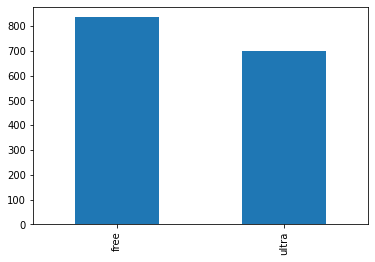

In [36]:
counts = clients['subscription_type'].value_counts() # подсчитываем количество значений
counts.plot(kind='bar')


Пользователей без подписки больше, однако не сильно, видимо условие подписки очень выгодное, и те кто ездит часто ее приобритает

Для графика я выбрал биномиальное распределение, тк тут у нас независимые события, в которых есть 2 исхода


Здесь нужно просто взять всех уникальных пользователей и поделить на два лагеря: с подпиской и без.

- Тк в clients хронятся долько уникальные пользователи, то в free_users и ultra_users я храню эти значения

Далее посчитать какую долю от общего количества занимает каждый.



In [37]:
free_users / clients.shape[0]

0.5443285528031291

In [38]:
ultra_users / clients.shape[0]

0.4556714471968709

А вот и доли, тут тоже видно, что пользователей без подписки на данный момент больше

Отобразить это соотношение лучше на круговой диаграмме - она нагляднее показывает части целого.

- Смотрим


<AxesSubplot:ylabel='user_id'>

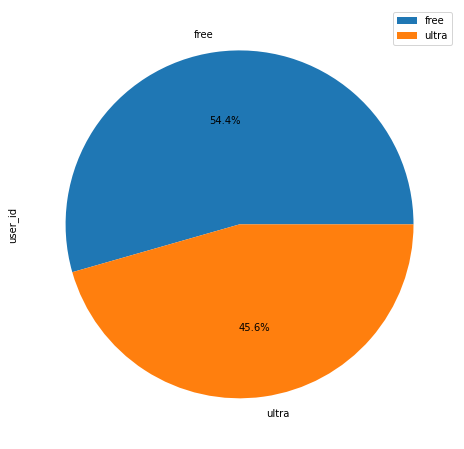

In [39]:
df_sub = clients.groupby('subscription_type').agg({'user_id': 'count'})
df_sub.plot(kind='pie', y='user_id', autopct='%1.1f%%', figsize=(8, 8))

**Возраст пользователей**

<AxesSubplot:>

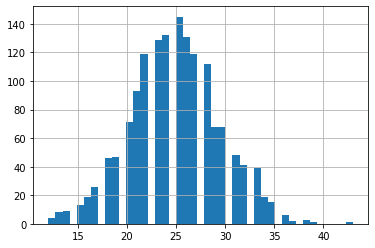

In [40]:
clients['age'].hist(bins=43)

Для отображения информации о возрасте пользователей, я выбрал гистограмму, тк возрас - дискретная велечина, а гистрограмма хорошо покажет как часто встречаются такие велечины в таблице

График выглядик похожим на нормальное распределение, но с пропусками в возрасте, как мы уже выяснили выше - средний возраст 24 года

In [41]:
clients['age'].describe()

count    1534.000000
mean       24.903520
std         4.572367
min        12.000000
25%        22.000000
50%        25.000000
75%        28.000000
max        43.000000
Name: age, dtype: float64

Максимальный возраст - 45 года, а минимальный - 12, в этом диапозоне значения и лежат, медиан равна 25, а основной возраст пользователей 22 - 28 года

**Расстояние, которое пользователь проехал**

Тк это непрерывная велечина, то чтобы наглядно отобразить я использую box plot

<AxesSubplot:>

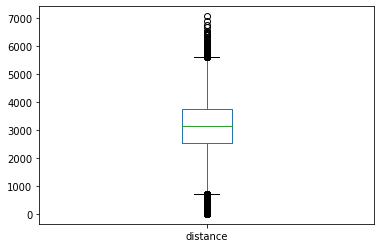

In [42]:
rides['distance'].plot.box()

In [43]:
rides['distance'].describe()

count    17973.000000
mean      3059.863833
std       1108.814612
min          0.855683
25%       2538.839628
50%       3129.029255
75%       3762.636244
max       7066.003772
Name: distance, dtype: float64

Хорошо видно, что средняя дистанция это 3км, скорее всего это поездки, которые взяли от станции метро или остановки чтобы доехать до какого-то пункта быстрее или туда, куда не идет транспорт, долгие поездки чуть реже. Они есть, но менее популярны.

Видно, что много выбросов, думаю, что можно от них избавиться в дальнейшем.

**Время, которое пользователь проехал**

<AxesSubplot:>

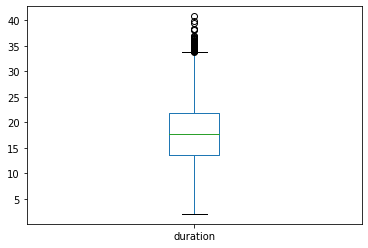

In [44]:
rides['duration'].plot.box()

In [45]:
rides['duration'].describe()

count    17973.000000
mean        17.896480
std          5.975424
min          2.035632
25%         13.670439
50%         17.714122
75%         21.747016
max         40.823963
Name: duration, dtype: float64

Обычно ездят 17мин, скорее всего это те самые 3км, по графику видно, что нормой считается поездка до 35мин, а максимум есть 40, не уверен что мы должны игнорировать эти данные в этом случае, но запомним, что можем попробовать их откинуть, если исследование потребует этого

<div class="alert-success" style="padding: 20px; border-radius: 10px">
<b>Комментарий ревьюера ✔️</b>

Дистанция и длительность поездок визуализированы и прокомментированы правильно.

Можно также использовать гистограммы, чтобы посмотреть распределения.</div>

**Частота встречаемости городов**

In [46]:
frequency = clients['city'].value_counts() / clients.shape[0]
display(frequency)
#проверим
frequency.sum()

Пятигорск         0.142764
Екатеринбург      0.132986
Ростов-на-Дону    0.129074
Краснодар         0.125815
Сочи              0.123207
Омск              0.119296
Тюмень            0.117340
Москва            0.109518
Name: city, dtype: float64

1.0

<AxesSubplot:>

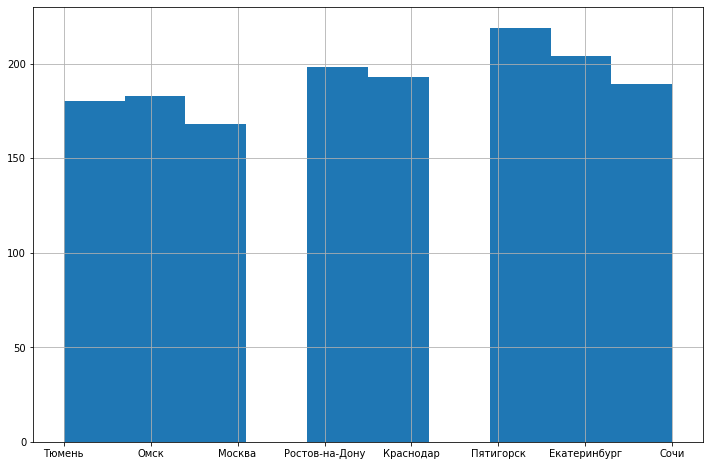

In [47]:
clients['city'].hist(figsize=(12,8) )

Text(0, 0.5, 'Частота')

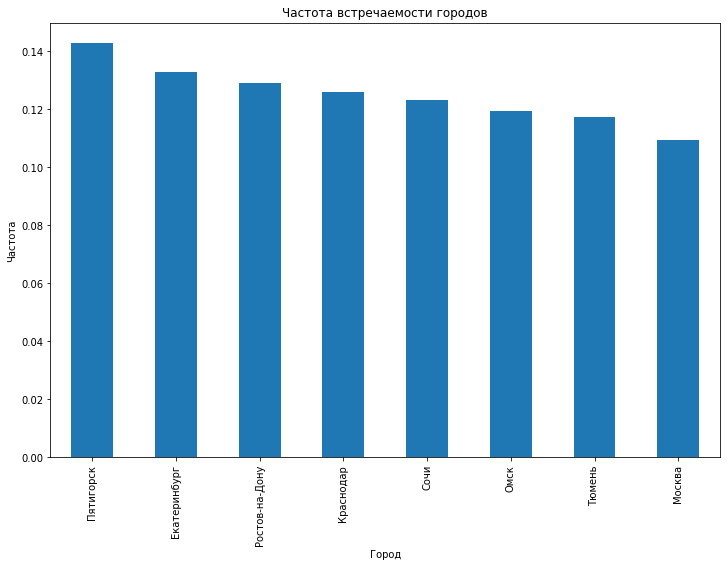

In [48]:
frequency = clients['city'].value_counts(normalize=True)

frequency.plot(kind='bar', figsize=(12,8))


plt.title('Частота встречаемости городов')
plt.xlabel('Город')
plt.ylabel('Частота')

В целом, разница между городами не сильно велика, более-менее самокаты равномерно распределены, но Пятигорск в текущей таблице одирживает лидерство

Что касается времени и дальности поездки - то никаких аномальных и странных значений нет, все данные имеет право ну существоание, осталось разобраться есть ли сущ. разница между пользователями с подпиской и без нее

####  Объединение данных

Объеденим датафреймы в один

In [49]:
merged_df = pd.merge(clients, subs, on='subscription_type')
merged_df = pd.merge(merged_df, rides, on='user_id')
merged_df

,user_id,name,age,city,subscription_type,minute_price,start_ride_price,subscription_fee,distance,duration,date,month,year,mean_speed
0,1,Кира,22,Тюмень,ultra,6,0,199,4409.919140,25.599769,2021-01-01,1,2021,172.264021
1,1,Кира,22,Тюмень,ultra,6,0,199,2617.592153,15.816871,2021-01-18,1,2021,165.493673
2,1,Кира,22,Тюмень,ultra,6,0,199,754.159807,6.232113,2021-04-20,4,2021,121.011887
3,1,Кира,22,Тюмень,ultra,6,0,199,2694.783254,18.511000,2021-08-11,8,2021,145.577402
4,1,Кира,22,Тюмень,ultra,6,0,199,4028.687306,26.265803,2021-08-28,8,2021,153.381465
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17968,1534,Альберт,25,Краснодар,free,8,50,0,3781.098080,19.822962,2021-11-04,11,2021,190.743349
17969,1534,Альберт,25,Краснодар,free,8,50,0,2840.423057,21.409799,2021-11-16,11,2021,132.669299
17970,1534,Альберт,25,Краснодар,free,8,50,0,3826.185507,18.435051,2021-11-18,11,2021,207.549490
17971,1534,Альберт,25,Краснодар,free,8,50,0,2902.308661,16.674362,2021-11-27,11,2021,174.058151


Отлично, теперь все в одном, но теперь снова делилм. Посмотрим на разницу между пользователями с подпиской и без нее. Для этого и разделим датафрейм на этой основе

In [50]:
merged_df

,user_id,name,age,city,subscription_type,minute_price,start_ride_price,subscription_fee,distance,duration,date,month,year,mean_speed
0,1,Кира,22,Тюмень,ultra,6,0,199,4409.919140,25.599769,2021-01-01,1,2021,172.264021
1,1,Кира,22,Тюмень,ultra,6,0,199,2617.592153,15.816871,2021-01-18,1,2021,165.493673
2,1,Кира,22,Тюмень,ultra,6,0,199,754.159807,6.232113,2021-04-20,4,2021,121.011887
3,1,Кира,22,Тюмень,ultra,6,0,199,2694.783254,18.511000,2021-08-11,8,2021,145.577402
4,1,Кира,22,Тюмень,ultra,6,0,199,4028.687306,26.265803,2021-08-28,8,2021,153.381465
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17968,1534,Альберт,25,Краснодар,free,8,50,0,3781.098080,19.822962,2021-11-04,11,2021,190.743349
17969,1534,Альберт,25,Краснодар,free,8,50,0,2840.423057,21.409799,2021-11-16,11,2021,132.669299
17970,1534,Альберт,25,Краснодар,free,8,50,0,3826.185507,18.435051,2021-11-18,11,2021,207.549490
17971,1534,Альберт,25,Краснодар,free,8,50,0,2902.308661,16.674362,2021-11-27,11,2021,174.058151


In [51]:
subt = merged_df[merged_df['subscription_type'] == 'ultra']
subt['subscription_type'].unique()

array(['ultra'], dtype=object)

In [52]:
subn = merged_df[merged_df['subscription_type'] == 'free']
subn['subscription_type'].unique()

array(['free'], dtype=object)

Посмотрим на наших самокатеров

In [53]:
display(subt.head(15))
subn.head(15)

,user_id,name,age,city,subscription_type,minute_price,start_ride_price,subscription_fee,distance,duration,date,month,year,mean_speed
0,1,Кира,22,Тюмень,ultra,6,0,199,4409.919140,25.599769,2021-01-01,1,2021,172.264021
1,1,Кира,22,Тюмень,ultra,6,0,199,2617.592153,15.816871,2021-01-18,1,2021,165.493673
2,1,Кира,22,Тюмень,ultra,6,0,199,754.159807,6.232113,2021-04-20,4,2021,121.011887
3,1,Кира,22,Тюмень,ultra,6,0,199,2694.783254,18.511000,2021-08-11,8,2021,145.577402
4,1,Кира,22,Тюмень,ultra,6,0,199,4028.687306,26.265803,2021-08-28,8,2021,153.381465
5,1,Кира,22,Тюмень,ultra,6,0,199,2770.890808,16.650138,2021-10-09,10,2021,166.418490
6,1,Кира,22,Тюмень,ultra,6,0,199,3039.020292,14.927879,2021-10-19,10,2021,203.580180
7,1,Кира,22,Тюмень,ultra,6,0,199,2842.118050,23.117468,2021-11-06,11,2021,122.942446
8,1,Кира,22,Тюмень,ultra,6,0,199,3412.690668,15.238072,2021-11-14,11,2021,223.958167
9,1,Кира,22,Тюмень,ultra,6,0,199,748.690645,15.041884,2021-11-22,11,2021,49.773730


,user_id,name,age,city,subscription_type,minute_price,start_ride_price,subscription_fee,distance,duration,date,month,year,mean_speed
6500,700,Айдар,22,Омск,free,8,50,0,2515.690719,14.944286,2021-01-02,1,2021,168.337961
6501,700,Айдар,22,Омск,free,8,50,0,846.932642,16.234663,2021-02-01,2,2021,52.168168
6502,700,Айдар,22,Омск,free,8,50,0,4004.434142,20.016628,2021-02-04,2,2021,200.055381
6503,700,Айдар,22,Омск,free,8,50,0,1205.911290,9.782872,2021-02-10,2,2021,123.267611
6504,700,Айдар,22,Омск,free,8,50,0,3047.379435,17.427673,2021-02-14,2,2021,174.858655
6505,700,Айдар,22,Омск,free,8,50,0,4342.002254,22.368009,2021-02-23,2,2021,194.116618
6506,700,Айдар,22,Омск,free,8,50,0,3798.334905,18.243756,2021-03-03,3,2021,208.199174
6507,700,Айдар,22,Омск,free,8,50,0,2984.551206,15.424899,2021-04-09,4,2021,193.489195
6508,700,Айдар,22,Омск,free,8,50,0,3360.107141,16.765497,2021-06-12,6,2021,200.417987
6509,700,Айдар,22,Омск,free,8,50,0,2567.543847,11.312160,2021-06-23,6,2021,226.972030


Отлично, это нам понадобится для сравнительного анализа

Сейчас посмотрим на метры и время использования самокатов от 2 разные категории и увидим, как сильно график будет отличаться от общих показателей двух категории

<AxesSubplot:>

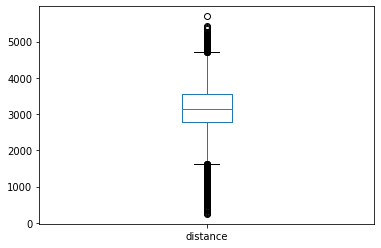

In [54]:
subt['distance'].plot.box()

In [55]:
subt['distance'].describe()

count    6500.000000
mean     3115.445388
std       836.895330
min       244.210438
25%      2785.444017
50%      3148.637229
75%      3560.574425
max      5699.769662
Name: distance, dtype: float64

<AxesSubplot:>

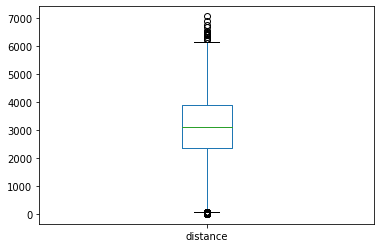

In [56]:
subn['distance'].plot.box()

In [57]:
subn['distance'].describe()

count    11473.000000
mean      3028.374239
std       1235.541051
min          0.855683
25%       2360.878149
50%       3102.083025
75%       3883.979311
max       7066.003772
Name: distance, dtype: float64

Не большая разница между пользователями с подпиской и без, среднее расстояние в районе 3000-3100м

<AxesSubplot:>

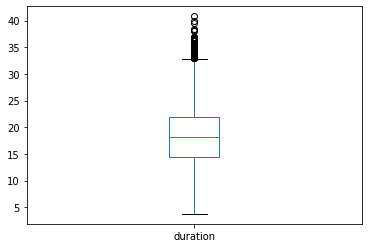

In [58]:
subt['duration'].plot.box()

In [59]:
subt['duration'].describe()

count    6500.000000
mean       18.541985
std         5.572048
min         3.760353
25%        14.524654
50%        18.178153
75%        21.884129
max        40.823963
Name: duration, dtype: float64

<AxesSubplot:>

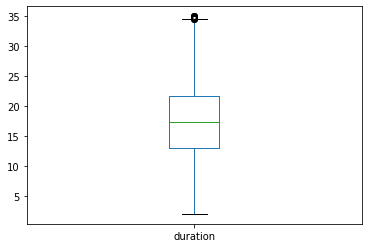

In [60]:
subn['duration'].plot.box()

In [61]:
subn['duration'].describe()

count    11473.000000
mean        17.530771
std          6.162609
min          2.035632
25%         13.085688
50%         17.383807
75%         21.638038
max         34.948498
Name: duration, dtype: float64

Время тоже не сильно отличется, в среднем буквально на минуту, у не имеющих подписку людей - максимум по времени 35мин, у имеющих 40. Вряд ли тут дело в цене, разница не большая для максимального значения, это не закономерность

In [62]:
subt.shape


(6500, 14)

In [63]:
subn.shape

(11473, 14)

Забыл проверить раньше, пользователей без подписки прилично поменьше

Хочу проверить, разнятся ли значения у пользователей с подпиской и без нее

- Нулевая гипотеза - Время которое пользователи с подпиской и без подписки трятят на поездку одинаковое, тоже самое про дистанцию
- Альтернативная - Оно разнится
- Я указал equal_var=False -тк выборки очень разнятся по размеру и представляют собой две разные группы

In [64]:

alpha = .01 


results = st.ttest_ind(subt['distance'], subn['distance'], equal_var=False)

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу') 

p-значение: 2.0426852749988446e-08
Отвергаем нулевую гипотезу


In [65]:
alpha = .01 


results = st.ttest_ind(subt['duration'], subn['duration'], equal_var=False)

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу') 

p-значение: 3.2324420390622126e-29
Отвергаем нулевую гипотезу


####  Подсчёт выручки

In [66]:
merged_df.head(15)

,user_id,name,age,city,subscription_type,minute_price,start_ride_price,subscription_fee,distance,duration,date,month,year,mean_speed
0,1,Кира,22,Тюмень,ultra,6,0,199,4409.919140,25.599769,2021-01-01,1,2021,172.264021
1,1,Кира,22,Тюмень,ultra,6,0,199,2617.592153,15.816871,2021-01-18,1,2021,165.493673
2,1,Кира,22,Тюмень,ultra,6,0,199,754.159807,6.232113,2021-04-20,4,2021,121.011887
3,1,Кира,22,Тюмень,ultra,6,0,199,2694.783254,18.511000,2021-08-11,8,2021,145.577402
4,1,Кира,22,Тюмень,ultra,6,0,199,4028.687306,26.265803,2021-08-28,8,2021,153.381465
5,1,Кира,22,Тюмень,ultra,6,0,199,2770.890808,16.650138,2021-10-09,10,2021,166.418490
6,1,Кира,22,Тюмень,ultra,6,0,199,3039.020292,14.927879,2021-10-19,10,2021,203.580180
7,1,Кира,22,Тюмень,ultra,6,0,199,2842.118050,23.117468,2021-11-06,11,2021,122.942446
8,1,Кира,22,Тюмень,ultra,6,0,199,3412.690668,15.238072,2021-11-14,11,2021,223.958167
9,1,Кира,22,Тюмень,ultra,6,0,199,748.690645,15.041884,2021-11-22,11,2021,49.773730


In [67]:
groupedsubt = subt.groupby(['user_id', 'month']).agg({'distance': 'sum', 'duration': 'sum', 'user_id': 'count'})
groupedsubt

distance   duration  user_id
user_id month                                 
1       1      7027.511294  41.416640        2
        4       754.159807   6.232113        1
        8      6723.470560  44.776802        2
        10     5809.911100  31.578017        2
        11     7003.499363  53.397424        3
...                    ...        ...      ...
699     6      4072.797406  16.575991        1
        8      7018.324143  44.281768        2
        9      6364.861911  30.282412        2
        10     4707.845501  15.839579        1
        12     3202.890770  25.217345        1

[4533 rows x 3 columns]

In [68]:
groupedsubn = subn.groupby(['user_id', 'month']).agg({'distance': 'sum', 'duration': 'sum', 'user_id': 'count'})
groupedsubn

distance   duration  user_id
user_id month                                  
700     1       2515.690719  14.944286        1
        2      13446.659764  85.829845        5
        3       3798.334905  18.243756        1
        4       2984.551206  15.424899        1
        6       5927.650988  28.077657        2
...                     ...        ...      ...
1534    6       3409.468534  24.812678        2
        8       7622.453034  47.205960        2
        9       4928.173852  22.560373        1
        11     13350.015305  76.342174        4
        12      2371.711192  15.893917        1

[6767 rows x 3 columns]

 Я сгруппировал сначала по id, чтобы выделить конкретного пользователя, а затем по месяцам, чтобы видеть общую статистику за каждый месяц, в котором конкретный пользователь использовал ваши самокаты. Теперь можно увидеть не только общее кол-во стартов, но и кол-во метров и минут в месяц

**Выручка**

Теперь посмотрим, сколько пользователь принес

In [69]:
groupedsubt['month_revenue'] =  groupedsubt['duration'].round() * 6 + 199
groupedsubt

distance   duration  user_id  month_revenue
user_id month                                                
1       1      7027.511294  41.416640        2          445.0
        4       754.159807   6.232113        1          235.0
        8      6723.470560  44.776802        2          469.0
        10     5809.911100  31.578017        2          391.0
        11     7003.499363  53.397424        3          517.0
...                    ...        ...      ...            ...
699     6      4072.797406  16.575991        1          301.0
        8      7018.324143  44.281768        2          463.0
        9      6364.861911  30.282412        2          379.0
        10     4707.845501  15.839579        1          295.0
        12     3202.890770  25.217345        1          349.0

[4533 rows x 4 columns]

In [70]:
groupedsubn['month_revenue'] =  groupedsubn['duration'].round() * 8 + groupedsubn['user_id'] * 50
groupedsubn

distance   duration  user_id  month_revenue
user_id month                                                 
700     1       2515.690719  14.944286        1          170.0
        2      13446.659764  85.829845        5          938.0
        3       3798.334905  18.243756        1          194.0
        4       2984.551206  15.424899        1          170.0
        6       5927.650988  28.077657        2          324.0
...                     ...        ...      ...            ...
1534    6       3409.468534  24.812678        2          300.0
        8       7622.453034  47.205960        2          476.0
        9       4928.173852  22.560373        1          234.0
        11     13350.015305  76.342174        4          808.0
        12      2371.711192  15.893917        1          178.0

[6767 rows x 4 columns]

In [71]:
# Код ревьюера
print(groupedsubn['month_revenue'].mean())
print(groupedsubt['month_revenue'].mean())

322.52312693955963
358.5380542686962


В среднем в месяц пользователи с подпиской действительно приносят больше, скорее всего все хорошо - система выгодна

####  Проверка гипотез

**Проверим, тратят ли пользователи с подпиской больше времени на поездки**

- Нулевую гипотезу составлю так - Пользователи с подпиской тратят на поездку столько же времени, сколько и пользователи без подписки

- Альтернативную - Пользователи с подпиской тратят больше времени на поездку

In [72]:
results = st.ttest_ind(subt['duration'], subn['duration'], equal_var=False, alternative='greater')

print('p-значение:', results.pvalue)
alpha = .05
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу') 

p-значение: 1.6162210195311063e-29
Отвергаем нулевую гипотезу


**Итог**

Получается, пользователи с подпиской, действительно тратят больше времени на поезду, чем пользователи без неё

*Проверим расстояние поездки*

Расстояние одной поездки в 3130 метров — оптимальное с точки зрения износа самоката. Проверим расстояние, которое проезжают пользователи с подпиской за одну поездку, меньше ли оно, чем 3130 метров?

In [73]:
value = 3130
results = st.ttest_1samp(
    subt['distance'], 
    value,
    alternative='less')

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print('Отвергаем нулевую гипотезу')
else:
    print('Не отвергаем нулевую гипотезу') 

p-значение: 0.08046311521502146
Не отвергаем нулевую гипотезу


**Итог**

Расстояние которое проезжают пользователи не меньше 3130(оптимального расстояния для одной поездки)

**Проверим выручку**

Будет ли выручка от пользователей с подпиской больше, чем у тех, кто ею не пользуется

In [74]:
results = st.ttest_ind(groupedsubt['month_revenue'], groupedsubn['month_revenue'], equal_var=False, alternative='greater')


print('p-значение:', results.pvalue)
alpha = .05
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу') 

p-значение: 1.2192607127486412e-45
Отвергаем нулевую гипотезу


**Итог**

Да, выручка с подписки идет больше, чем от одноразовой системы проката

# Шаг 7. Распределения

7.1 Отделу маркетинга GoFast поставили задачу: нужно провести акцию с раздачей промокодов на один бесплатный месяц подписки, в рамках которой как минимум 100 существующих клиентов должны продлить эту подписку. То есть по завершении периода действия подписки пользователь может либо отказаться от неё, либо продлить, совершив соотвествующий платёж. 
Эта акция уже проводилась ранее и по итогу выяснилось, что после бесплатного пробного периода подписку продлевают 10% пользователей. Выясните, какое минимальное количество промокодов нужно разослать, чтобы вероятность не выполнить план была примерно 5%. Подберите параметры распределения, описывающего эту ситуацию, постройте график распределения и сформулируйте ответ на вопрос о количестве промокодов.

In [75]:


n = 1158
p = 0.1
mu = n*p
sigma = sqrt(n * p * (1 - p))
distr_M = st.norm(mu, sigma) 

#
a = 99


print( round(1- distr_M.cdf(a),5))


0.95008


7.2 Отдел маркетинга рассылает клиентам push-уведомления в мобильном приложении. Клиенты могут открыть его или не открывать. Известно, что уведомления открывают около 40% получивших клиентов. Отдел планирует разослать 1 млн уведомлений. С помощью аппроксимации постройте примерный график распределения и оцените вероятность того, что уведомление откроют не более 399,5 тыс. пользователей.

In [76]:

n = 1000000
p = .4


mu = n * p
sigma = sqrt(n * p * (1 - p))


distr = st.norm(mu, sigma) 


result = distr.cdf(399500)
print(result)

0.15371708296369768


вероятность того, что уведомление откроют не более 399,5 тыс. пользователей, равна 15,37%

**Итог**

- Пользоватлей без подписки почти в 2 больше, чем пользователей с подпиской
- Прибыль с пользователей с подписой все же больше, чем с пользоваелей без нее, важный факт, учитывая кол-во пользователей с и без подписки
- Пользователи с подпиской проезжают не меньше оптимального расстояния в 3130м
- Группы пользоваетелей разнятся согласно Т-тесту по времени поездки и дальности, хоть, на первый взгляд это значения не кажется большим
- 1158 - это оценка кол-во промокодов, после применения которых, с вероятность 95% 100 пользователей продолжат пользоваться выгодной для компании подпиской